In [ ]:
!pip install sctour

In [3]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [4]:
adata = sc.read_h5ad('/lustre/groups/ml01/workspace/alejandro.tejada/cmp_unsorted_with_dyngen_style_velocities-2.h5ad')

In [5]:
adata.X

array([[0.24125536, 0.02630088, 0.05588026, ..., 0.03315685, 0.92290495,
        0.28817947],
       [0.26008206, 0.02725085, 0.06128555, ..., 0.0275297 , 0.85720762,
        0.28565944],
       [0.22215793, 0.01838462, 0.07223249, ..., 0.04085836, 0.66865533,
        0.25960152],
       ...,
       [0.31928061, 0.04047692, 0.06850542, ..., 0.04155105, 0.98345673,
        0.1981004 ],
       [0.0775247 , 0.06136695, 0.03816315, ..., 0.03815084, 0.30925988,
        0.1775551 ],
       [0.10582935, 0.07242282, 0.0901061 , ..., 0.04727637, 0.18827229,
        0.29851289]])

In [6]:
adata

AnnData object with n_obs × n_vars = 4224 × 4000
    obs: 'index', 'Seq_batch_ID', 'Amp_batch_ID', 'well_coordinates', 'Mouse_ID', 'Plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'RMT_sequence', 'Number_of_cells', 'CD34_measurement', 'FcgR3_measurement', 'n_counts_all', 'n_counts', 'velocity_self_transition'
    var: 'n_counts', 'highly_variable'
    uns: 'Batch_desc_colors', 'cebpa_ko_shortest_paths', 'cebpe_ko_shortest_paths', 'neighbors', 'pca', 'umap', 'unsorted_shortest_paths', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'X', 'counts', 'velocity'
    obsp: 'connectivities', 'distances'
    varp: 'grn_adj_mat'

In [7]:
adata.X = adata.layers['counts']

In [8]:
adata.X

array([[0., 0., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 5., 2.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 3.]], dtype=float32)

## Preprocess data

In [9]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

## Train model

It uses raw counts and NB loss

The alpha parameters regulate the trade-off between reconstruction of the encoder-based latent space (lec) and reconstruction of the neural ODEb-based latent space (lode)

In [12]:
tnode = sct.train.Trainer(adata, loss_mode='nb', alpha_recon_lec=0.5, alpha_recon_lode=0.5)
tnode.train()

Running using GPU.
/home/icb/alejandro.tejada/miniconda3/envs/enco/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph'] that happens to be dimensioned at n_obs×n_obs (4224×4224).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/icb/alejandro.tejada/miniconda3/envs/enco/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (4224×4224).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
Epoch 400: 100%|██████████| 400/400 [05:05<00:00,  1.31epoch/s, train_loss=769, val_loss=776]      


## Learn dynamics

In [14]:
adata.obs['sctour_ptime'] = tnode.get_time()

In [15]:
adata.obs['sctour_ptime']

3072    0.965949
3073    0.953536
3074    0.978935
3075    0.940699
3076    0.838930
          ...   
3067    0.138891
3068    0.733809
3069    0.464256
3070    0.634664
3071    0.178583
Name: sctour_ptime, Length: 4224, dtype: float32

In [16]:
#zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
#mix_zs represents the weighted combination of the two, which is used for downstream analysis
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata.obsm['sctour_X_TNODE'] = mix_zs

In [17]:
adata.obsm['sctour_X_VF'] = tnode.get_vector_field(adata.obs['sctour_ptime'].values, adata.obsm['sctour_X_TNODE'])


In [18]:
adata.obsm['sctour_X_VF'].shape

(4224, 5)

In [19]:
adata.obsm['sctour_X_VF']

array([[ 2.0412092e+00, -3.4482641e+00,  1.2492363e+00, -1.7169662e+00,
         9.7638555e-04],
       [ 1.9461129e+00, -3.4502175e+00,  1.2655876e+00, -2.0211673e+00,
         3.2539546e-02],
       [ 1.9281116e+00, -3.6991415e+00,  1.3852515e+00, -2.3340669e+00,
        -4.0590040e-02],
       ...,
       [ 2.3905209e-01, -3.2184036e+00,  2.4604607e+00, -3.3003473e+00,
        -1.5470579e-02],
       [ 6.2570441e-01, -3.1481047e+00,  2.1189699e+00, -2.7559321e+00,
        -1.6518512e-01],
       [-1.0321143e+00, -1.7656271e+00,  2.3312604e+00, -2.5840962e+00,
         7.3810823e-02]], dtype=float32)

In [20]:
adata.obsm['sctour_X_TNODE'].shape

(4224, 5)

In [23]:
adata.obs

,index,Seq_batch_ID,Amp_batch_ID,well_coordinates,Mouse_ID,Plate_ID,Batch_desc,Pool_barcode,Cell_barcode,RMT_sequence,Number_of_cells,CD34_measurement,FcgR3_measurement,n_counts_all,n_counts,velocity_self_transition,n_genes_by_counts,total_counts,sctour_ptime
3072,W42817,SB20,AB234,A1,3,10,CMP Flt3+ Csf1r+,ACTT,CTACCA,NNNN,1,NaN,NaN,2926.0,428.209163,0.025336,458,760.0,0.965949
3073,W42818,SB20,AB234,C1,3,10,CMP Flt3+ Csf1r+,ACTT,CATGCT,NNNN,1,NaN,NaN,2894.0,425.576399,0.006436,481,782.0,0.953536
3074,W42819,SB20,AB234,E1,3,10,CMP Flt3+ Csf1r+,ACTT,GCACAT,NNNN,1,NaN,NaN,2402.0,435.528970,0.140291,459,763.0,0.978935
3075,W42820,SB20,AB234,G1,3,10,CMP Flt3+ Csf1r+,ACTT,TGCTCG,NNNN,1,NaN,NaN,3076.0,426.568660,0.034382,525,883.0,0.940699
3076,W42821,SB20,AB234,I1,3,10,CMP Flt3+ Csf1r+,ACTT,AGCAAT,NNNN,1,NaN,NaN,2679.0,454.548075,0.007403,494,810.0,0.838930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,W39164,SB19,AB214,H24,2,9,Unsorted myeloid,TAAG,GCATTG,NNNN,1,78.0,11.0,5926.0,391.273905,0.598909,671,1371.0,0.138891
3068,W39165,SB19,AB214,J24,2,9,Unsorted myeloid,TAAG,GGCTAA,NNNN,1,773.0,1600.0,4299.0,466.070564,0.067899,601,1271.0,0.733809
3069,W39166,SB19,AB214,L24,2,9,Unsorted myeloid,TAAG,CTGTGA,NNNN,1,205.0,233.0,567.0,520.385963,0.009126,183,220.0,0.464256
3070,W39167,SB19,AB214,N24,2,9,Unsorted myeloid,TAAG,CATGCA,NNNN,1,151.0,527.0,3913.0,517.598193,0.094156,627,1281.0,0.634664


/home/icb/alejandro.tejada/miniconda3/envs/enco/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alejandro.tejada/miniconda3/envs/enco/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


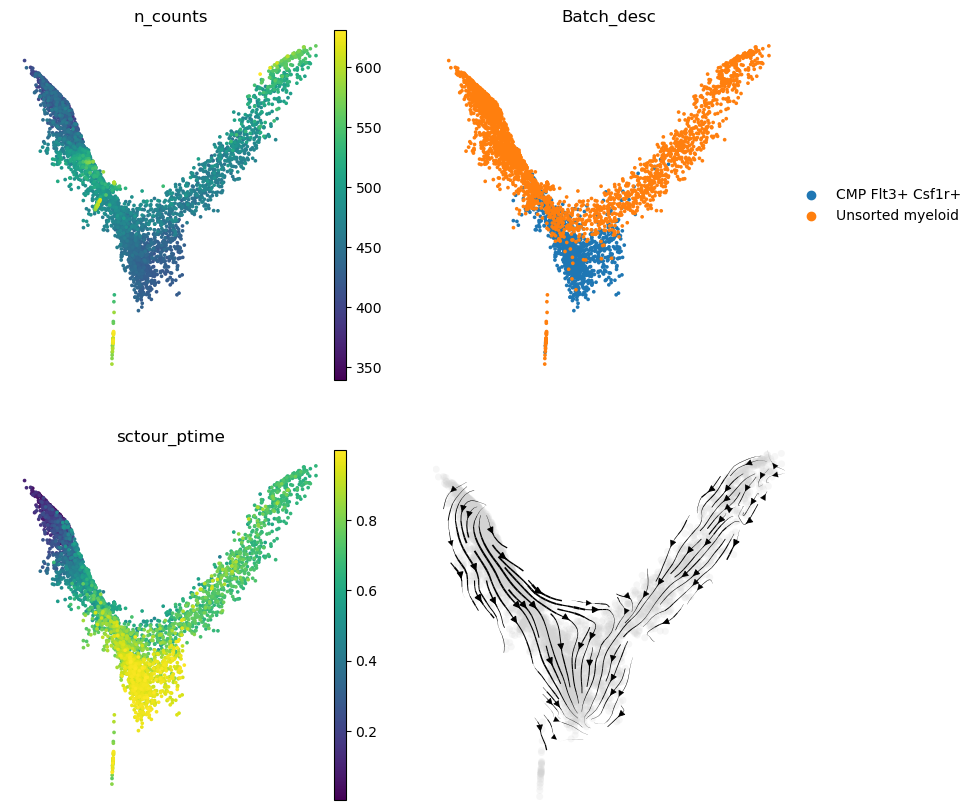

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.umap(adata, color='n_counts', ax=axs[0, 0], legend_loc='on data', show=False, frameon=False)
sc.pl.umap(adata, color='Batch_desc', ax=axs[0, 1], show=False, frameon=False)
sc.pl.umap(adata, color='sctour_ptime', ax=axs[1, 0], show=False, frameon=False)
sct.vf.plot_vector_field(adata, zs_key='sctour_X_TNODE', vf_key='sctour_X_VF', use_rep_neigh='sctour_X_TNODE', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()

In [25]:
adata.obs['sctour_ptime'] = sct.train.reverse_time(adata.obs['sctour_ptime'].values)

/home/icb/alejandro.tejada/miniconda3/envs/enco/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


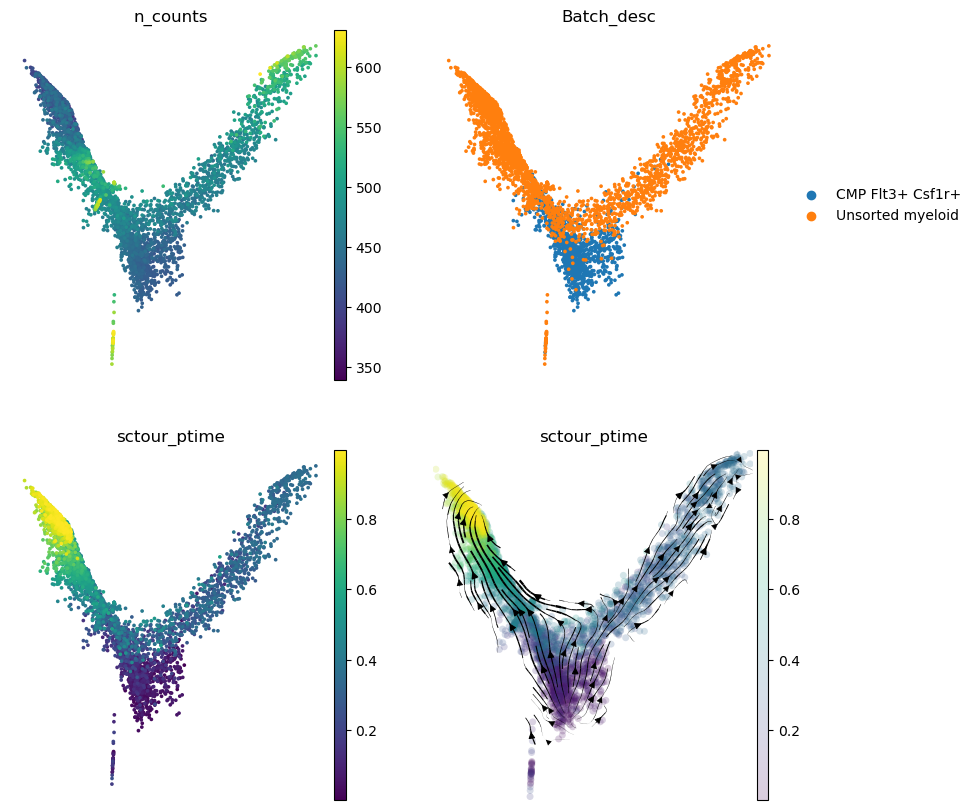

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.umap(adata, color='n_counts', ax=axs[0, 0], legend_loc='on data', show=False, frameon=False)
sc.pl.umap(adata, color='Batch_desc', ax=axs[0, 1], show=False, frameon=False)
sc.pl.umap(adata, color='sctour_ptime', ax=axs[1, 0], show=False, frameon=False)
sct.vf.plot_vector_field(adata, reverse=True, zs_key='sctour_X_TNODE', vf_key='sctour_X_VF', use_rep_neigh='sctour_X_TNODE', show=False, ax=axs[1, 1], legend_loc='none', color = 'sctour_ptime', frameon=False, size=100, alpha=0.2)
plt.show()

In [31]:
adata.write('/home/icb/alejandro.tejada/FLeCS/datasets/Benchmark/scTour.h5ad')